# Used libraries and their usage

In [1]:
# Basic libraries
import numpy as np # library for working with arrays
import matplotlib.pyplot as plt # library for data plotting
import pandas as pd # library for storing and manipulating with data
from scipy import integrate # flibrary or numerical integration
import scipy.optimize as optimization # library for data fitting
from urllib import request # library used for downloading and opening some constants from golem wiki
plt.rcParams["font.weight"] = "bold" # these two lines are used to make text bold in figures
plt.rcParams["axes.labelweight"] = "bold"

In [71]:
# function for downloading and storing data into variables. *argv is used to overflow number of 
# inputs, when we want to get data from rigol
def get_data(shot,identifier,name,what):
    # if no argv is given or is given by None and idintifier is correct, this try bellow will load data from
    # standard diagnostic
    if(what == 'basic'):
        data = pd.read_csv(f'http://golem.fjfi.cvut.cz/shots/{shot}/DASs/StandardDAS/{identifier}.csv',
                          names = ['t','data'])
    elif(what== 'rigol'):
    # if argv is given (in form of b,d or e due to rigol we want to load), following read_cvs will be called 
    # and data loaded
        path = f'http://golem.fjfi.cvut.cz/shots/{shot}/Devices/Oscilloscopes/{name}/{identifier}.csv'
#         print(path)
        data = pd.read_csv(path, names = ['t','data'])
    # convert time axis from s to ms
    data.t = data.t*1000
    # removing offset (it is based on making mean of first few values of the signal)
    data.data -= data.data[0:10].mean()
    return data

In [48]:
# loading raw data from rigol e
Rigol_line = 'RigolMSO5204-d'
rig = Rigol_line
# shot 0 means the last shot
#shot = 34243
#shot_no = 36109
shot_no = 38593
shot = shot_no
Uloop = get_data(shot,f'U_Loop',rig,'rigol')
Rogowski = get_data(shot,f'U_RogCoil',rig,'rigol')
Bt_coil = get_data(shot,f'U_BtCoil',rig,'rigol')
Photodiode = get_data(shot,f'U_photod',rig,'rigol')
# Bt_coil.head()

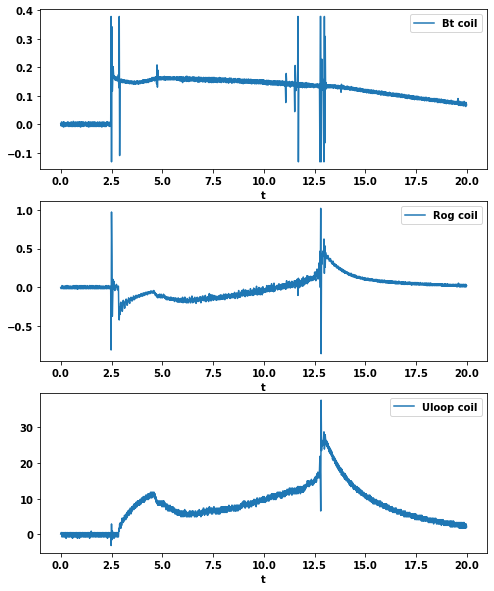

In [49]:
# Checking if offset is removed correctly
fig,ax = plt.subplots(nrows = 3, figsize = (8,10))
Bt_coil[['t','data']][Bt_coil.t<20].plot(x='t',ax=ax[0])
ax[0].legend(['Bt coil'])
Rogowski[['t','data']][Bt_coil.t<20].plot(x='t',ax=ax[1])
ax[1].legend(['Rog coil'])
Uloop[['t','data']][Bt_coil.t<20].plot(x='t',ax=ax[2])
ax[2].legend(['Uloop coil'])

# Optional task
This task can be performed optionally. Chamber resistance is determined by measuring loop voltage and chamber current during vacuum shot. Chamber resistance is then determined by fiting dependency of Ich on Uloop by Ohms law

In [53]:
def get_vacuum_shot(shot, identifier):
    data = pd.read_csv(f'http://golem.fjfi.cvut.cz/shots/{shot}/DASs/StandardDAS/{identifier}.csv',
                      names = ['t','data'])
    data.t = data.t*1000
    # removing offset (it is based on making mean of first few values of the signal)
    return data
# getting vacuum shot for resistance determination
shot_vac = 34176
Uloop_vac = get_vacuum_shot(shot_vac,'LoopVoltageCoil_raw')
Rogowski_vac = get_vacuum_shot(shot_vac,'RogowskiCoil_raw')

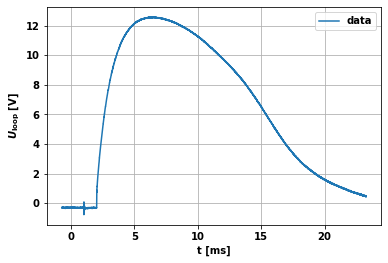

In [54]:
# Uloop in vacuum shot
fig,ax = plt.subplots(1)
Uloop_vac[['t', 'data']].plot(x='t',ax=ax)
# ax.plot(Uloop_vac.t,Uloop_vac.data)
ax.set_xlabel('t [ms]')
ax.set_ylabel(r'$U_\mathrm{loop}$ [V]')
ax.grid(True)

In [55]:
K_Ip = 5.3e6
# Calculation of chamber current during vacuum shot
#K_Ip = np.loadtxt(request.urlopen(f'http://golem.fjfi.cvut.cz/utils/data/{shot}/K_RogowskiCoil'))
# Numerical integration of Rogowski coil signl using cumtrapz function
Ich_vac = pd.DataFrame({'t':Rogowski_vac.t,'data':-integrate.cumtrapz(Rogowski_vac.data, Rogowski_vac.t/1000, initial=0)*K_Ip/1000})

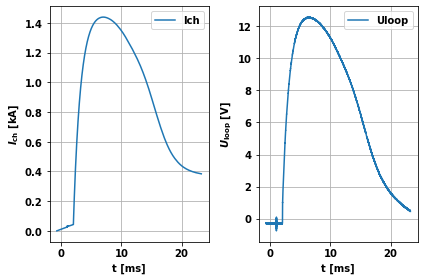

In [56]:
# both Uloop and chamber current duting vacuum shot
fig,ax = plt.subplots(ncols=2)
Ich_vac[['t', 'data']].plot(x='t',ax=ax[0],label = 'Ich')
ax[0].grid(True)
ax[0].set_xlabel('t [ms]')
ax[0].set_ylabel(r'$I_\mathrm{ch}$ [kA]')
Uloop_vac[['t', 'data']].plot(x='t',ax=ax[1])
ax[1].set_xlabel('t [ms]')
ax[1].set_ylabel(r'$U_\mathrm{loop}$ [V]')
ax[1].grid(True)
ax[0].legend(["Ich"])
ax[1].legend(["Uloop"])

plt.tight_layout()

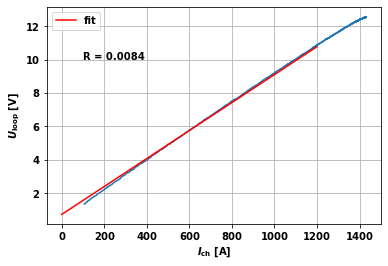

In [70]:
# Vacuum chmaber resistance determination. Dependency of Uloop on chamber current is fitted by Ohms law
def Ohm_law(I,R,b):
    return R*I+b

tt1 = 2800; tt2=7000
fig,ax = plt.subplots(1)
ax.plot(Ich_vac.data[tt1:tt2]*1000,Uloop_vac.data[tt1:tt2])
# this is where the fit is performed
popt, pcov = optimization.curve_fit(Ohm_law,Ich_vac.data[tt1:tt2]*1000, Uloop_vac.data[tt1:tt2])
x = np.linspace(0,1200,100)
ax.plot(x,Ohm_law(x,*popt),color = 'red', label = 'fit')
ax.text(100,10,'R = ' + str(round(popt[0],4)))
ax.set_xlabel(r'$I_\mathrm{ch}$ [A]')
ax.set_ylabel(r'$U_\mathrm{loop}$ [V]')
plt.legend()
R = popt[0]
ax.grid(True)

# Main task

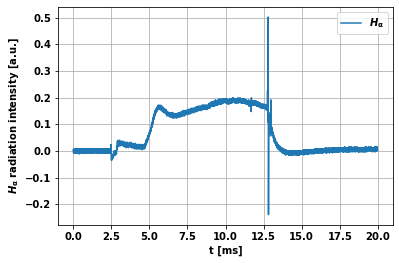

In [29]:
fig,ax = plt.subplots(1)
Photodiode[['t', 'data']].plot(x='t',ax=ax)
ax.set_xlabel('t [ms]')
ax.set_ylabel(r'$H_\mathrm{\alpha}$ radiation intensity [a.u.]')
ax.grid(True)
ax.legend([r'$H_\mathrm{\alpha}$'])

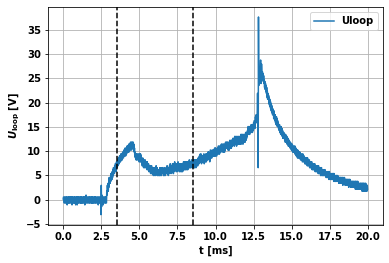

In [30]:
# Uloop of current shot
fig,ax = plt.subplots(1)
Uloop[['t', 'data']].plot(x='t',ax=ax)
T_s = 3.5
T_e = 8.5
ax.axvline(x = T_s,color = 'black',linestyle = '--')
ax.axvline(x = T_e,color = 'black',linestyle = '--')
ax.set_xlabel('t [ms]')
ax.set_ylabel(r'$U_\mathrm{loop}$ [V]')
ax.grid(True)
ax.legend(['Uloop'])

In [31]:
# Integration of raw Bt coil signal for obtaining toroidal magnetic field.
K_Bt = 70.42
#K_Bt = np.loadtxt(request.urlopen(f'http://golem.fjfi.cvut.cz/utils/data/{shot}/K_BtCoil'))
Bt = pd.DataFrame({'t':Bt_coil.t,'data':integrate.cumtrapz(Bt_coil.data, Bt_coil.t/1000, initial=0)*K_Bt})

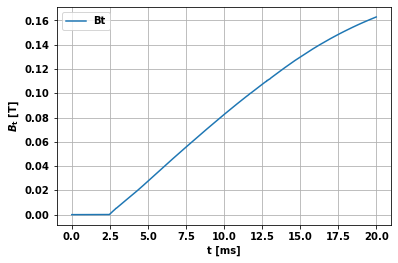

In [32]:
fig,ax = plt.subplots(1)
Bt[['t', 'data']].plot(x='t',ax=ax)
ax.set_xlabel('t [ms]')
ax.set_ylabel(r'$B_\mathrm{t}$ [T]')
ax.grid(True)
ax.legend(['Bt'])

In [33]:
# Computation of total current during discharge (chamber + plasma)
Iall = pd.DataFrame({'t':Rogowski.t,'data':(-1)*integrate.cumtrapz(Rogowski.data, Rogowski.t/1000*0.84, initial=0)*K_Ip/1000})

In [34]:
# Computation of plasma current
R=0.0091
#R = np.loadtxt(request.urlopen(f'http://golem.fjfi.cvut.cz/utils/data/{shot}/R_chamber'))
Ip = pd.DataFrame({'t':Rogowski.t,'data':(Iall.data*1000 - Uloop.data/R)/1000})
Ich = pd.DataFrame({'t':Rogowski.t,'data':Uloop.data/R/1000})

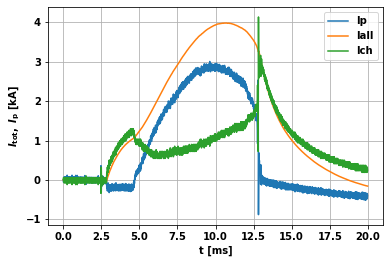

In [35]:
# Summary figure of currents (plasma current, chamber current and total current)
fig,ax = plt.subplots(1)
(Ip[['t', 'data']]).plot(x='t',ax=ax)
(Iall[['t', 'data']]).plot(x='t',ax=ax)
(Ich[['t', 'data']]).plot(x='t',ax=ax)
ax.grid(True)
# plt.legend()
ax.set_xlabel('t [ms]')
ax.set_ylabel(r'$I_\mathrm{tot}, \ I_\mathrm{p}$ [kA]')
ax.legend(['Ip','Iall','Ich'])

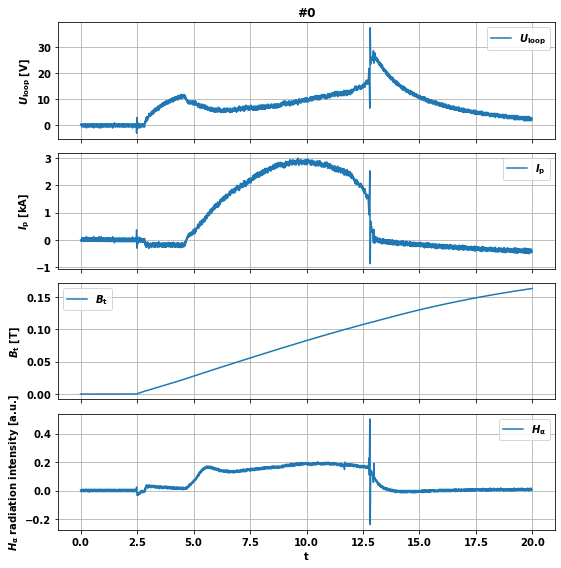

In [36]:
fig,ax = plt.subplots(nrows=4,sharex=True, figsize=(8,8))
Uloop[['t', 'data']].plot(x='t',ax=ax[0],grid=True)
Ip[['t', 'data']].plot(x='t',ax=ax[1],grid=True)
Bt[['t', 'data']].plot(x='t',ax=ax[2],grid=True)
# ax[0].plot(datax,datay)
Photodiode[['t', 'data']].plot(x='t',ax=ax[3],grid=True)
ax[0].set_title('#'+str(shot),fontweight = 'bold')
ax[0].set_ylabel(r'$U_\mathrm{loop}$ [V]')
ax[0].legend(['$U_\mathrm{loop}$'])
ax[1].set_ylabel(r'$I_\mathrm{p}$ [kA]')
ax[1].legend([r'$I_\mathrm{p}$'])
ax[2].set_ylabel(r'$B_\mathrm{t}$ [T]')
ax[2].legend([r'$B_\mathrm{t}$'])
ax[3].set_ylabel(r'$H_\mathrm{\alpha}$ radiation intensity [a.u.]')
ax[3].legend([r'$H_\mathrm{\alpha}$'])
plt.tight_layout()
plt.savefig(f'icon-fig-{rig}.png')

In [37]:
# COmputation of electron temperature
Te = pd.DataFrame({'t':Rogowski.t,'data':0.9*(Uloop.data/(Ip.data*1000))**(-2/3)})

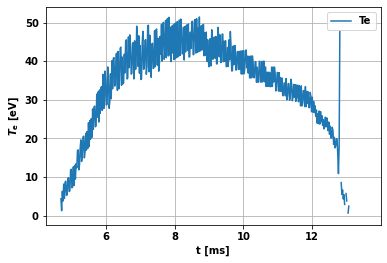

In [38]:
fig,ax = plt.subplots(1)
Te[['t', 'data']][(Te.t>3) & (Te.t<15)].plot(x='t',ax=ax)
ax.set_xlabel('t [ms]')
ax.set_ylabel(r'$T_\mathrm{e}$ [eV]')
ax.grid(True)
ax.legend(['Te'])

In [39]:
Vp = 80e-3
Vch = 150e-3
kb=1.38e-23
T0 = 300
p0=15.8e-3#1013e2
e=1.6e-19

In [40]:
# Computation of plasma density
ne = (2*p0*Vch)/(kb*T0*Vp)
print(ne)

1.431159420289855e+19


In [41]:
# Computation of confinement time
tau = pd.DataFrame({'t':Rogowski.t,'data':(e*ne*Te.data*Vp)/(3*Uloop.data*Ip.data)})

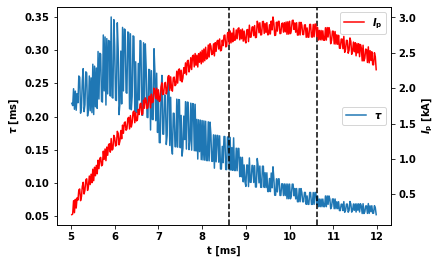

In [42]:
flattop = ()
fig,ax = plt.subplots(1)
tau[['t','data']][((tau.t>5) & (tau.t<12))].plot(x='t',ax=ax)
ax2 = ax.twinx()
(Ip[['t', 'data']])[((tau.t>5) & (tau.t<12))].plot(x='t',ax=ax2,color = 'red')
ax.set_xlabel('t [ms]')
ax.set_ylabel(r'$\tau$ [ms]')
ax.legend([r'$\tau$'],loc = 'center right')
ax2.legend([r'$I_\mathrm{p}$'])
ax2.set_ylabel(r'$I_\mathrm{p}$ [kA]')
ax.axvline(x = Ip.t[Ip.data.idxmax()]-1,color = 'black',linestyle = '--')
ax.axvline(x = Ip.t[Ip.data.idxmax()]+1,color = 'black',linestyle = '--')

Text(0, 0.5, '$\\tau$ [ms]')

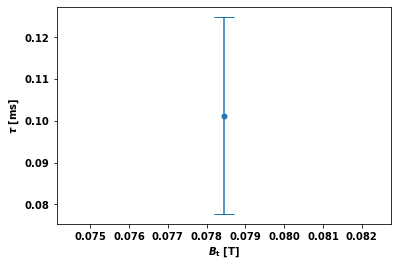

In [44]:
# Confinement time during quasistationary phase of the discharge
tau_mean = (tau[((tau.t>Ip.t[Ip.data.idxmax()]-1) & (tau.t<Ip.t[Ip.data.idxmax()]+1))]).mean()
tau_std = tau[((tau.t>Ip.t[Ip.data.idxmax()]-1) & (tau.t<Ip.t[Ip.data.idxmax()]+1))].std()
fig,ax = plt.subplots()
ax.errorbar(Bt.data[Ip.data.idxmax()-1:Ip.data.idxmax()+1].mean(),
            tau_mean.data,yerr = tau_std.data,markersize = 10,fmt = 'C0.',capsize=10)
ax.set_xlabel(r'$B_\mathrm{t}$ [T]')
ax.set_ylabel(r'$\tau$ [ms]')

<ErrorbarContainer object of 3 artists>

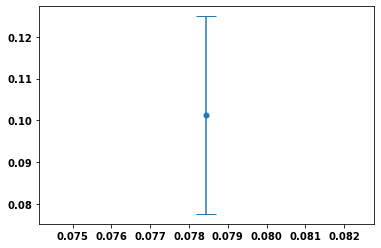

In [45]:
Bt_mean = Bt.data[Ip.data.idxmax()-1:Ip.data.idxmax()+1].mean()
Bt_std = Bt.data[Ip.data.idxmax()-1:Ip.data.idxmax()+1].std()


output = [shot, tau_mean,tau_std,Bt_mean,Bt_std]


fig,ax = plt.subplots(1)
ax.errorbar(Bt_mean,tau_mean.data,yerr = tau_std.data,markersize = 10,fmt = 'C0.',capsize=10)